In [103]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style('white') 

## Predictive Maintenance Dataset

https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

In [109]:
# loads the dataset
predictive_maintenance = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv')

# drops some unnecessary columns
predictive_maintenance = predictive_maintenance.drop(columns = ['UDI', 'Product ID'])

# One hot encoding categorical features
encoder = OneHotEncoder().fit(predictive_maintenance[['Type']])
encoder.categories_

transformed = encoder.transform(predictive_maintenance[['Type']] ).toarray() 
transformed

for index, category in enumerate( np.concatenate(encoder.categories_) ):
    predictive_maintenance[category] = transformed[:,index] 

# Drops columns
predictive_maintenance = predictive_maintenance.drop(columns = ['Type','Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])

# Moves columns to the front
cols = predictive_maintenance.columns.tolist()
cols = cols[-3:] + cols[:-3]
predictive_maintenance = predictive_maintenance[cols]

predictive_maintenance

,H,L,M,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0.0,0.0,1.0,0,0,0,0,0,0
1,0.0,1.0,0.0,0,0,0,0,0,0
2,0.0,1.0,0.0,0,0,0,0,0,0
3,0.0,1.0,0.0,0,0,0,0,0,0
4,0.0,1.0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,1.0,0,0,0,0,0,0
9996,1.0,0.0,0.0,0,0,0,0,0,0
9997,0.0,0.0,1.0,0,0,0,0,0,0
9998,1.0,0.0,0.0,0,0,0,0,0,0


In [110]:
# Stores all columns except Machine Failure in X and Machine Failure in Y
X_p = predictive_maintenance.drop(['Machine failure'], axis = 1)
Y_p = predictive_maintenance['Machine failure']

# Gets 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, train_size = 5000, random_state = 1)

In [111]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [112]:
best_model = clf.fit(X_train, Y_train)

In [113]:
best_model.cv_results_

{'mean_fit_time': array([8.73217583e-03, 1.48085594e-02, 3.93505096e-03, 1.25985146e-02,
        5.50675392e-03, 1.20497704e-02, 1.46453857e-02, 1.30670547e-02,
        2.07205296e-02, 2.28023529e-02, 8.56017590e-02, 8.98850441e-02,
        3.30595064e-01, 3.93773270e-01, 6.43287468e-01, 2.36050320e-01,
        6.70819569e-01, 4.99674225e-01, 7.82075238e+00, 5.17470646e+00,
        6.61056056e+00, 9.03301535e+00, 1.24118055e+01, 1.40310344e+01,
        2.15291192e+01, 3.28871756e+01, 3.95746841e+01, 1.80694236e+01,
        5.88468266e-01]),
 'std_fit_time': array([9.40382268e-04, 4.35265670e-03, 1.93065471e-05, 8.86803563e-04,
        9.37554245e-04, 4.91459860e-04, 1.38588226e-03, 5.70623506e-04,
        1.02530301e-03, 1.79310377e-03, 1.98359006e-02, 5.32165376e-03,
        5.00375193e-02, 3.81673322e-02, 6.97760987e-02, 7.57179719e-03,
        2.35208006e-02, 9.20236049e-03, 3.16791198e-01, 5.68911507e-01,
        3.76315230e-01, 6.74330474e-01, 5.92710960e-01, 1.51667433e+00,
     

In [114]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [115]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [116]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [117]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [118]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 0.1, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [119]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0338
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0338
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0338
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0338
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0338
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0338
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0050
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0316
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0010
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0010


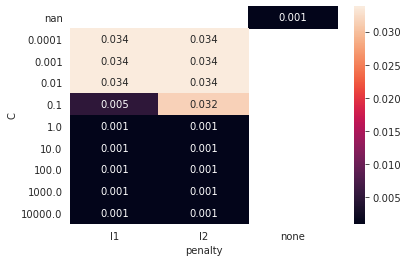

In [120]:
# takes best parameters from model and stores in results
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [123]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, train_size = 5000, random_state = 2)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [124]:
best_model = clf.fit(X_train, Y_train)

In [125]:
best_model.cv_results_

{'mean_fit_time': array([7.29956627e-03, 1.40727043e-02, 4.58426476e-03, 1.45000935e-02,
        6.58988953e-03, 1.26875877e-02, 1.60831451e-02, 1.26404285e-02,
        1.92502499e-02, 2.48710155e-02, 1.08905411e-01, 9.44427490e-02,
        3.14712954e-01, 3.11866093e-01, 5.21699190e-01, 2.14859629e-01,
        5.68522120e-01, 4.25639057e-01, 7.60827408e+00, 4.99142694e+00,
        6.29541774e+00, 8.75341964e+00, 1.24310036e+01, 1.42726592e+01,
        2.06522368e+01, 3.25507079e+01, 2.93468446e+01, 1.85749039e+01,
        5.42206144e-01]),
 'std_fit_time': array([3.35227425e-03, 1.19815357e-03, 3.01163245e-04, 1.48633157e-03,
        8.82584001e-04, 1.28617187e-04, 2.70622984e-03, 4.68317268e-04,
        2.09653701e-03, 2.67543253e-03, 1.89410332e-02, 6.52419097e-03,
        3.36281607e-02, 3.29874255e-02, 1.04263931e-01, 3.13402825e-02,
        9.42194377e-02, 7.47077723e-02, 2.77823122e-01, 2.30796070e-01,
        2.83515744e-01, 4.75912939e-01, 5.97344341e-01, 6.03182035e-01,
     

In [126]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [127]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [128]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [129]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [130]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [131]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0350
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0350
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0350
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0350
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0350
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0350
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0042
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0320
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0012
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0012


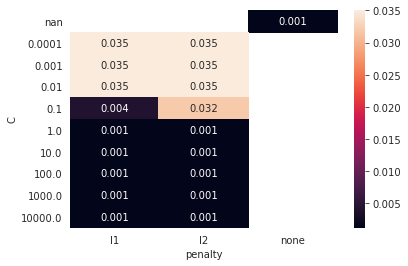

In [132]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [133]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, train_size = 5000, random_state = 3)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [134]:
best_model = clf.fit(X_train, Y_train)

In [135]:
best_model.cv_results_

{'mean_fit_time': array([8.39147568e-03, 1.86957359e-02, 6.39357567e-03, 1.39684677e-02,
        5.48634529e-03, 1.29612923e-02, 1.58883572e-02, 1.35078430e-02,
        1.89266682e-02, 2.24709511e-02, 8.37059021e-02, 9.80743408e-02,
        3.14213371e-01, 3.18510962e-01, 5.95688152e-01, 2.83915901e-01,
        6.86443853e-01, 5.03534079e-01, 8.28354816e+00, 5.05144224e+00,
        6.13011703e+00, 8.41364989e+00, 1.37752024e+01, 1.51347686e+01,
        2.17729976e+01, 2.56920614e+01, 3.13337306e+01, 1.67340251e+01,
        8.92442989e-01]),
 'std_fit_time': array([1.03592436e-03, 4.90579914e-03, 1.18514022e-03, 1.68243957e-03,
        1.08134947e-03, 5.53101539e-04, 1.07909984e-03, 1.29098390e-03,
        2.02096064e-03, 1.60101108e-03, 2.08450727e-02, 3.34689905e-02,
        2.50126356e-02, 1.51334953e-02, 3.75548932e-02, 4.98433997e-02,
        3.92339078e-02, 2.00138668e-02, 4.37735909e-01, 4.27076742e-01,
        2.78775084e-01, 6.86867564e-01, 1.25252548e+00, 4.97991225e-01,
     

In [136]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [137]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [138]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [139]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [140]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 0.1, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [141]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0352
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0352
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0352
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0352
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0352
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0352
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0036
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0340
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0010
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0010


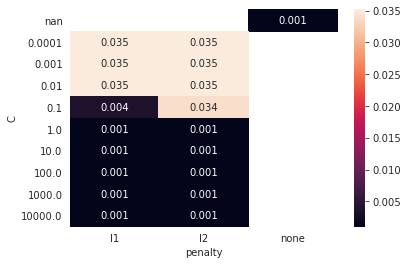

In [142]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [143]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, train_size = 5000, random_state = 4)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [144]:
best_model = clf.fit(X_train, Y_train)

In [145]:
best_model.cv_results_

{'mean_fit_time': array([8.79807472e-03, 3.80117893e-02, 4.21433449e-03, 1.44897461e-02,
        6.24480247e-03, 1.19880199e-02, 1.84023380e-02, 2.15517998e-02,
        2.20106602e-02, 2.63590813e-02, 1.09934330e-01, 9.71488953e-02,
        3.49275351e-01, 3.57771921e-01, 6.85887480e-01, 2.81907701e-01,
        7.10621786e-01, 5.79707050e-01, 7.42375445e+00, 4.69340639e+00,
        5.60879254e+00, 8.67295914e+00, 1.10508671e+01, 1.56095476e+01,
        1.92277944e+01, 2.83326004e+01, 4.65309328e+01, 1.69901748e+01,
        8.40160513e-01]),
 'std_fit_time': array([1.46896008e-03, 4.32837025e-02, 7.17524110e-05, 1.06358764e-03,
        3.83467171e-04, 6.17823106e-04, 3.12727585e-03, 4.07904242e-03,
        2.48881969e-03, 1.39684806e-03, 2.75485847e-02, 6.55908496e-03,
        3.35033948e-02, 3.18701847e-02, 8.32289293e-02, 5.51666372e-02,
        4.10289440e-02, 6.10813560e-02, 4.26243419e-01, 2.24150578e-01,
        3.64650944e-01, 6.39827646e-01, 1.08233478e+00, 5.04401431e-01,
     

In [146]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [147]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [148]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [149]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [150]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [151]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0338
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0338
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0338
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0338
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0338
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0338
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0050
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0316
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0008
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0008


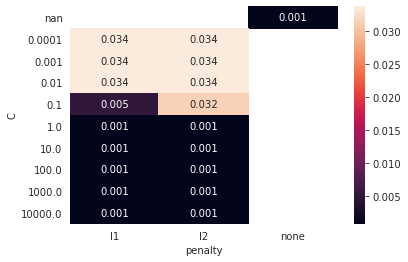

In [152]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [153]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_p, Y_p, train_size = 5000, random_state = 5)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [154]:
best_model = clf.fit(X_train, Y_train)

In [155]:
best_model.cv_results_

{'mean_fit_time': array([8.05716515e-03, 1.35886669e-02, 3.90424728e-03, 2.52711773e-02,
        1.38176441e-02, 1.76843643e-02, 1.80134296e-02, 1.46399498e-02,
        2.01443672e-02, 2.29954243e-02, 8.63862514e-02, 1.04141712e-01,
        2.74066734e-01, 2.94428635e-01, 5.09094524e-01, 2.61963749e-01,
        5.37478781e-01, 3.79064178e-01, 6.52566643e+00, 5.53680096e+00,
        5.79611068e+00, 8.79254298e+00, 1.26281224e+01, 1.67087855e+01,
        2.26097698e+01, 3.26507159e+01, 3.38891936e+01, 2.00530329e+01,
        5.53521442e-01]),
 'std_fit_time': array([1.22471444e-03, 1.31999169e-03, 7.22567380e-05, 7.03241766e-03,
        2.66107299e-03, 3.31996427e-03, 1.77083694e-03, 9.19376067e-04,
        6.37091501e-04, 1.15436382e-03, 1.98514036e-02, 3.13178233e-02,
        3.61589038e-02, 1.41366283e-02, 8.43994323e-02, 1.65991975e-02,
        1.29605954e-01, 6.02506829e-02, 4.84994646e-01, 6.87462046e-01,
        5.03857511e-01, 6.94797894e-01, 7.86425793e-01, 1.24668969e+00,
     

In [156]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [157]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [158]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [159]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [160]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [161]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0308
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0308
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0308
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0308
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0308
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0308
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0042
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0294
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0012
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0012


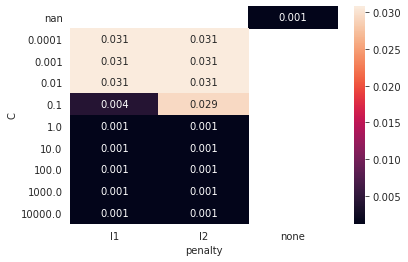

In [162]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

## Nursery Dataset

https://archive.ics.uci.edu/ml/datasets/Nursery

In [6]:
# loads the dataset
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data')

# One hot encoding categorical features
encoder = OneHotEncoder().fit(nursery[['usual', 'proper', 'complete', '1', 'convenient', 'convenient.1', 'nonprob', 'recommended', 'recommend']])
encoder.categories_

transformed = encoder.transform(nursery[['usual', 'proper', 'complete', '1', 'convenient', 'convenient.1', 'nonprob', 'recommended', 'recommend']] ).toarray() 
transformed

for index, category in enumerate( np.concatenate(encoder.categories_) ):
    nursery[category] = transformed[:,index]

# drops string
nursery = nursery.drop(columns = ['convenient.1'])

In [7]:
# Stores column of 'recommended' in Y and everything else in X
X_n = nursery.drop(['recommended'], axis=1)
Y_n = nursery['recommended']

# Gets 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_n, train_size = 5000, random_state = 1)

In [8]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [9]:
best_model.cv_results_

{'mean_fit_time': array([ 0.02307649,  0.11751189,  0.08169107,  0.0652987 ,  0.08869057,
         0.06145024,  0.10587187,  0.10534363,  0.10086846,  0.05995722,
         0.3030612 ,  0.0978456 ,  0.79018316,  0.2921824 ,  1.180968  ,
         0.59027834,  1.36558022,  0.940275  ,  1.88439226,  2.01818752,
         3.70361366,  6.78337994, 11.26564779, 15.17122102, 13.86626244,
        14.82763925, 12.03784986,  8.88008046,  1.01320662]),
 'std_fit_time': array([0.01770207, 0.0407875 , 0.03441407, 0.03466978, 0.06845308,
        0.03605945, 0.04363092, 0.02575898, 0.01464443, 0.00983802,
        0.05156189, 0.03129921, 0.0488595 , 0.06509395, 0.05282872,
        0.01981934, 0.0713995 , 0.05890705, 0.1660693 , 0.16457808,
        0.1660934 , 0.72163876, 2.6529995 , 5.61154348, 2.34979053,
        5.12087694, 2.91378879, 0.56222005, 0.04595151]),
 'mean_score_time': array([0.35781288, 0.34926834, 0.43400278, 0.43200822, 0.36819334,
        0.41169744, 0.3931076 , 0.35319238, 0.31511993,

In [10]:
best_model.cv_results_['rank_test_accuracy']

array([23, 23, 23, 23, 23, 21, 20, 18,  1, 16,  4,  2,  5,  5,  5,  5,  5,
        5, 23, 23, 21, 19, 16,  2,  5,  5,  5,  5,  5], dtype=int32)

In [11]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [12]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10000.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [13]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [14]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 10000.0, solver = 'lbfgs', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [15]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3380
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3380
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3380
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.3380
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.3380
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2872
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2566
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2544
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2506
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2520


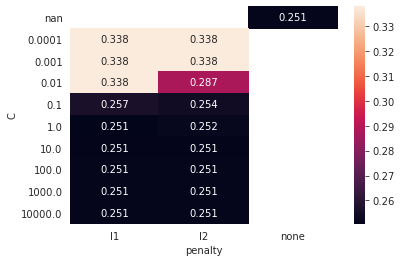

In [16]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [17]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_n, train_size = 5000, random_state = 2)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [18]:
best_model.cv_results_

{'mean_fit_time': array([0.02998857, 0.10862293, 0.04048257, 0.10956979, 0.07948799,
        0.09539418, 0.08309288, 0.09117475, 0.12296891, 0.08824272,
        0.30968804, 0.08748875, 0.79067402, 0.2479919 , 1.18628297,
        0.5873836 , 1.20706973, 0.84744816, 1.70134592, 2.00617523,
        3.85136938, 6.23425245, 6.29951396, 8.03522058, 8.88846951,
        7.11537995, 6.7382607 , 8.73282523, 1.04518313]),
 'std_fit_time': array([0.03257373, 0.06722819, 0.03576323, 0.07651821, 0.03595007,
        0.03840588, 0.03760614, 0.03928223, 0.0448688 , 0.04501427,
        0.0267905 , 0.04819836, 0.04963065, 0.05240054, 0.0593546 ,
        0.05333394, 0.05096814, 0.01950021, 0.10724526, 0.25485731,
        0.28267362, 0.54041345, 0.65164483, 0.93989466, 0.44491343,
        0.44758353, 0.33718295, 0.59441762, 0.07746295]),
 'mean_score_time': array([0.40037107, 0.37114868, 0.39802594, 0.35427604, 0.33521085,
        0.36470776, 0.38907638, 0.39747262, 0.3902998 , 0.38969731,
        0.407246

In [19]:
best_model.cv_results_['rank_test_accuracy']

array([23, 23, 23, 23, 23, 22, 20, 18,  3,  1,  4,  4,  4,  4,  4,  4,  4,
        4, 23, 23, 21, 18,  1,  4,  4,  4,  4,  4,  4], dtype=int32)

In [20]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [21]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [22]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [23]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 10.0, solver = 'lbfgs', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 5000)

In [24]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3344
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3344
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3344
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.3344
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.3344
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2814
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2494
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2464
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2428
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2422


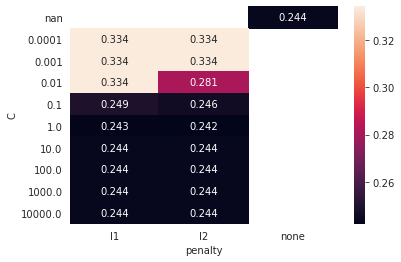

In [25]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [26]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_n, train_size = 5000, random_state = 3)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

best_model.cv_results_

{'mean_fit_time': array([ 0.04132781,  0.0553369 ,  0.0206233 ,  0.07869158,  0.0754611 ,
         0.05882297,  0.07956381,  0.05916357,  0.12629533,  0.06013761,
         0.30690532,  0.1418036 ,  0.75461044,  0.2838213 ,  1.16981878,
         0.60323648,  1.36170797,  0.9407948 ,  1.83269782,  2.06996036,
         3.67276406,  6.92614217, 11.89898486, 18.89465222, 15.29383435,
        16.36994853, 11.74633565,  8.83539972,  0.99570513]),
 'std_fit_time': array([3.91493853e-02, 3.84694583e-02, 3.95072461e-03, 4.75975780e-02,
        4.69848978e-02, 4.15866311e-02, 3.57077259e-02, 3.85265994e-02,
        4.88622490e-02, 1.98781913e-02, 3.69104327e-02, 6.08388970e-02,
        4.66057086e-02, 6.83448053e-02, 4.78769707e-02, 2.75529005e-02,
        8.06537104e-02, 5.18731308e-02, 1.83265895e-01, 2.57451393e-01,
        2.97146866e-01, 7.58217751e-01, 1.96206772e+00, 5.54964349e+00,
        4.79478213e+00, 4.77286227e+00, 3.77098793e+00, 6.44089886e-01,
        4.33345657e-02]),
 'mean_sco

In [27]:
best_model.cv_results_['rank_test_accuracy']

array([23, 23, 23, 23, 23, 22, 20, 18, 14, 16,  1,  5,  5,  1,  5,  5,  5,
        5, 23, 23, 21, 18, 17,  1,  1, 15,  5,  5,  5], dtype=int32)

In [28]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [31]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__penalty': 'none',
 'classifier__solver': 'lbfgs'}

In [30]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [32]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'none', solver = 'lbfgs', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

In [33]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=10.0, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3342
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3342
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3342
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.3342
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.3342
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2886
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2568
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2520
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2492
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2496


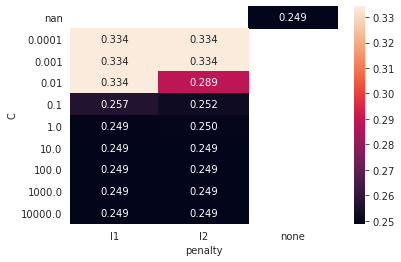

In [34]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [35]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_n, train_size = 5000, random_state = 4)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

best_model.cv_results_

{'mean_fit_time': array([0.01268663, 0.06456165, 0.05586877, 0.07757716, 0.14525533,
        0.1257731 , 0.07584252, 0.12821651, 0.10619478, 0.06906295,
        0.25276761, 0.07654109, 0.77723947, 0.26902099, 1.12408385,
        0.55224543, 1.22705922, 0.93094144, 1.88278441, 2.03703909,
        3.65650449, 6.15462947, 9.47885423, 7.94882188, 9.7581264 ,
        6.37127547, 7.53912578, 9.05100579, 0.99063253]),
 'std_fit_time': array([0.00359346, 0.05041488, 0.04962205, 0.04043397, 0.03633988,
        0.04527296, 0.03594642, 0.01414065, 0.03104086, 0.03743426,
        0.04181683, 0.05442691, 0.04120711, 0.0751404 , 0.04241632,
        0.01922817, 0.07207089, 0.06847979, 0.08631932, 0.17383194,
        0.3271211 , 0.19472231, 0.66458839, 1.07562786, 0.89882124,
        0.42186721, 0.58631491, 0.48963498, 0.0529984 ]),
 'mean_score_time': array([0.37255921, 0.34964457, 0.40596867, 0.35757117, 0.34041719,
        0.39353485, 0.34076033, 0.36993847, 0.37828689, 0.34048023,
        0.363759

In [36]:
best_model.cv_results_['rank_test_accuracy']

array([23, 23, 23, 23, 23, 21,  1,  2,  6,  9, 11,  4, 11,  7, 11, 11, 11,
       11, 23, 23, 21,  2,  9,  4,  7, 11, 11, 11, 11], dtype=int32)

In [37]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [38]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [39]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [40]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.1, solver = 'saga', max_iter = 5000)

In [41]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.1, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3262
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3262
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3262
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.3262
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.3262
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2860
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2394
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2426
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2452
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2456


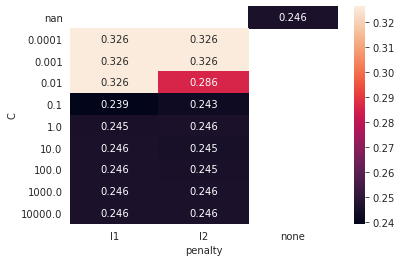

In [42]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [43]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_n, train_size = 5000, random_state = 5)

# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

best_model.cv_results_

{'mean_fit_time': array([0.03211646, 0.05520263, 0.05361867, 0.07580819, 0.10961943,
        0.09246459, 0.05646873, 0.10602975, 0.06320229, 0.05404658,
        0.28535981, 0.10385919, 0.76024055, 0.20742297, 1.12947741,
        0.55214663, 1.17560663, 0.88086915, 1.96779518, 2.06159544,
        3.71086445, 6.59772124, 6.53578658, 8.28970447, 8.92674985,
        6.48857708, 7.32077894, 8.79292727, 1.05867271]),
 'std_fit_time': array([0.03826974, 0.03294739, 0.07392525, 0.07152151, 0.03937377,
        0.04768518, 0.01050633, 0.05801818, 0.00360056, 0.02969555,
        0.03034425, 0.05272746, 0.05215864, 0.03329252, 0.06156623,
        0.02628047, 0.04822373, 0.04348587, 0.17892352, 0.22838283,
        0.2219246 , 0.5711834 , 1.32437809, 0.96684709, 0.65446314,
        0.14876899, 0.75567363, 0.44072776, 0.05411436]),
 'mean_score_time': array([0.41992588, 0.41936936, 0.32443061, 0.37987065, 0.40855098,
        0.35272288, 0.31375937, 0.3701293 , 0.36884742, 0.3289115 ,
        0.373196

In [44]:
best_model.cv_results_['rank_test_accuracy']

array([24, 24, 24, 24, 23, 21, 20, 18,  7,  3,  3,  1,  7,  7,  7,  7,  7,
        7, 24, 24, 21, 19,  3,  1,  6,  7,  7,  7,  7], dtype=int32)

In [45]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [46]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10000.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [47]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [48]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 10000.0, solver = 'lbfgs', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l2', C = 10.0, solver = 'saga', max_iter = 5000)

In [49]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=10.0, max_iter=5000, solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3386
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3386
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3386
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.3386
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.3228
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.2784
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.2532
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.2520
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.2492
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.2488


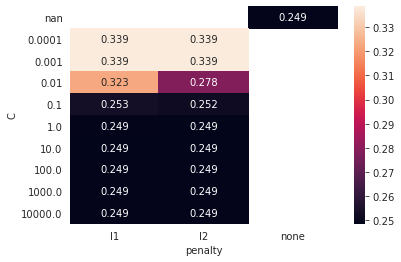

In [50]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

## Electrical Grid Stability Dataset

https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

In [2]:
# electrical grid stability dataset
electrical_grid = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv')

# One hot encoding categorical features
encoder = OneHotEncoder().fit(electrical_grid[['stabf']])
encoder.categories_

transformed = encoder.transform(electrical_grid[['stabf']] ).toarray() 

for index, category in enumerate( np.concatenate(encoder.categories_) ):
    electrical_grid[category] = transformed[:,index]

# moves columns so dataset looks better
cols = electrical_grid.columns.tolist()
cols = cols[-2:] + cols[:-2]
electrical_grid = electrical_grid[cols]

# drops string so grid search can work
electrical_grid = electrical_grid.drop(columns = ['stabf'])
    
electrical_grid

,stable,unstable,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab
0,0.0,1.0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347
1,1.0,0.0,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957
2,0.0,1.0,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471
3,0.0,1.0,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871
4,0.0,1.0,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1.0,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892
9996,1.0,0.0,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803
9997,1.0,0.0,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810
9998,0.0,1.0,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789


In [3]:
# Stores all columns except Stable in X and Stable in Y
X_e = electrical_grid.drop(['stable'], axis = 1)
Y_e = electrical_grid['stable']

In [53]:
# Gets 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_e, Y_e, train_size = 5000, random_state = 1)

In [54]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [55]:
best_model.cv_results_

{'mean_fit_time': array([1.37479782e-02, 5.03918171e-02, 4.18791771e-02, 6.90973282e-02,
        8.87124062e-02, 1.22159481e-01, 2.55944729e-01, 2.06146955e-01,
        5.41491699e-01, 1.58962202e-01, 9.43674088e-01, 3.38988876e-01,
        1.08593531e+00, 7.44097948e-01, 1.09123306e+00, 8.55287075e-01,
        1.09014015e+00, 8.68636942e-01, 4.24791017e+00, 6.28330245e+00,
        1.09594289e+01, 1.44813404e+01, 1.76972996e+01, 2.09154312e+01,
        1.95536808e+01, 2.09915684e+01, 1.73499521e+01, 7.31463947e+00,
        1.32173398e+01]),
 'std_fit_time': array([2.18820757e-03, 3.88400491e-02, 2.00414763e-03, 1.83969962e-02,
        3.48112810e-02, 4.23193977e-02, 4.70048516e-02, 4.46390978e-02,
        4.28876022e-02, 4.34851019e-02, 4.63664095e-02, 2.24607016e-02,
        3.10261404e-02, 5.18818598e-02, 4.84407509e-02, 4.75792502e-02,
        6.35519837e-02, 3.58069855e-02, 3.07760261e-01, 2.72971513e-01,
        9.59418410e-01, 1.76025345e+00, 1.66878196e+00, 2.51664164e+00,
     

In [56]:
best_model.cv_results_['rank_test_accuracy']

array([29, 26, 28, 25,  1, 22,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 23,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [57]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [58]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [59]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [60]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

In [61]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3602
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3012
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3592
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1568
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0000
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0036
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0000
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0000
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


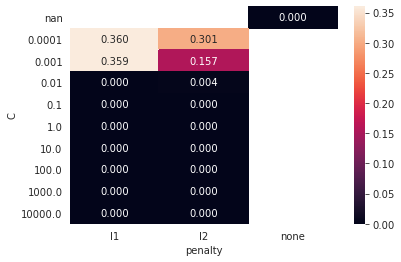

In [62]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [64]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_e, Y_e, train_size = 5000, random_state = 2)

In [65]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [66]:
best_model.cv_results_

{'mean_fit_time': array([ 0.030302  ,  0.05632143,  0.0684936 ,  0.08468285,  0.09605503,
         0.15583663,  0.27367854,  0.24228244,  0.54786248,  0.16387272,
         0.98270669,  0.34033065,  1.08175263,  0.72956386,  1.07880397,
         1.34810314,  1.71697969,  0.84873657,  4.00383677,  6.02129035,
        10.95708971, 17.98321676, 22.78804016, 25.47369709, 26.4383152 ,
        23.72850428, 17.67766709,  8.12173805, 12.24841008]),
 'std_fit_time': array([0.03680901, 0.03940837, 0.03695682, 0.02801624, 0.04169001,
        0.04754297, 0.06814371, 0.01578433, 0.02883902, 0.02711478,
        0.04473895, 0.01808714, 0.05369413, 0.03174991, 0.02402426,
        0.34846736, 0.42870067, 0.05286786, 0.2533839 , 0.26445594,
        0.82263036, 2.71433426, 2.78223401, 1.98518291, 3.35870291,
        1.93959867, 2.15491453, 1.46364921, 0.8148947 ]),
 'mean_score_time': array([0.35324197, 0.37744966, 0.3544517 , 0.3333395 , 0.36565976,
        0.31982646, 0.36401954, 0.39567132, 0.36895208,

In [67]:
best_model.cv_results_['rank_test_accuracy']

array([29, 26, 28, 24,  1, 22,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 22,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [68]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [69]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [70]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [71]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

In [72]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3628
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3002
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3614
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1622
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0000
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0030
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0000
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0000
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


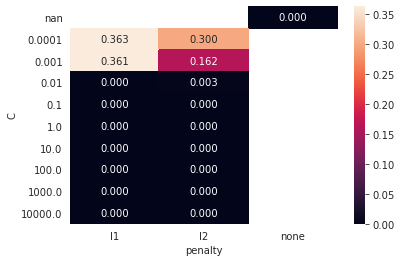

In [73]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [74]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_e, Y_e, train_size = 5000, random_state = 3)

In [75]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [76]:
best_model.cv_results_

{'mean_fit_time': array([ 0.06298399,  0.29773712,  0.4560709 ,  0.75060086,  0.86251283,
         1.71398954,  2.92315917,  2.50781269,  6.98469319,  1.68456874,
        13.26007714,  4.87179952,  8.36909261,  0.69277425,  1.06269665,
         0.81998377,  1.1146996 ,  0.86377592,  3.89572754,  6.13157163,
        11.67518516, 19.07212157, 22.35729327, 24.35158229, 24.8454556 ,
        24.71862106, 18.92820539,  8.41026821, 12.19708028]),
 'std_fit_time': array([0.04085164, 0.40186637, 0.73603078, 0.70381087, 0.95178903,
        0.82175917, 0.91646632, 0.62674188, 1.24485062, 0.22414079,
        0.80339771, 0.67564355, 6.38539714, 0.03417475, 0.05046803,
        0.03719137, 0.05595027, 0.03363895, 0.34503139, 0.38657477,
        0.2330232 , 3.56776114, 1.97263643, 4.09753678, 2.97311089,
        2.90953698, 2.82459877, 1.12774761, 2.31505625]),
 'mean_score_time': array([0.39366641, 0.70262399, 0.38840284, 0.51339726, 0.37514443,
        0.5645328 , 0.41524367, 0.3291369 , 0.32885561,

In [77]:
best_model.cv_results_['rank_test_accuracy']

array([29, 26, 28, 24,  1, 22,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 25, 23,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [78]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [79]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [80]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [81]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

In [82]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3646
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.3020
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3640
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1622
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0000
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0022
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0000
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0000
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


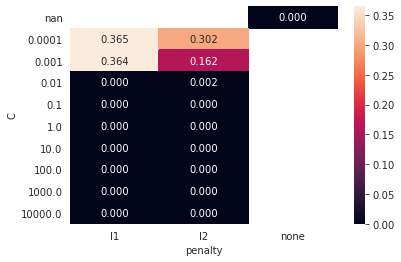

In [83]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [84]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_e, Y_e, train_size = 5000, random_state = 4)

In [85]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [86]:
best_model.cv_results_

{'mean_fit_time': array([ 0.22601151,  0.43601012,  0.64634614,  0.71485868,  1.10584936,
         1.74551649,  3.67404103,  2.7894186 ,  8.01760473,  1.67055182,
        15.42340331,  4.36484365, 18.05366025, 11.50476575, 16.31682878,
        12.20116477, 16.39952965, 15.07746878,  4.97312016,  8.98158865,
        13.00464673, 17.5458405 , 21.74188638, 26.85414324, 23.7325973 ,
        18.389572  , 13.51846571,  6.39971919,  0.94647779]),
 'std_fit_time': array([0.38713257, 0.69753975, 0.68070008, 0.71990872, 1.09409468,
        0.8271255 , 1.34997576, 0.57564888, 1.59598079, 0.21948737,
        1.9742616 , 0.77477336, 1.41249437, 1.98902154, 1.54230985,
        0.91302608, 0.98933015, 4.60149001, 1.05697639, 1.0206786 ,
        0.84195885, 1.41616236, 3.33271607, 3.29170386, 1.61607244,
        1.60767509, 1.18052309, 0.16459014, 0.04366687]),
 'mean_score_time': array([0.48056769, 0.78992801, 0.43832202, 0.77516913, 0.89150686,
        0.37270823, 0.58940787, 0.54913793, 0.64118943,

In [87]:
best_model.cv_results_['rank_test_accuracy']

array([29, 26, 28, 24,  1, 22,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 25, 22,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [88]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [89]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [90]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [91]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

In [92]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3640
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2958
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3622
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1634
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0000
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0028
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0000
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0000
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


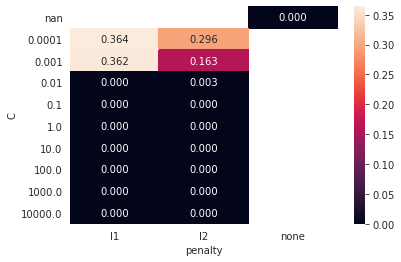

In [93]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [4]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_e, Y_e, train_size = 5000, random_state = 5)

In [5]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [6]:
best_model.cv_results_

{'mean_fit_time': array([4.30516243e-02, 1.17904139e-01, 1.23922586e-01, 1.40566206e-01,
        1.38671064e-01, 1.89089632e-01, 3.39349747e-01, 2.73952246e-01,
        6.38592720e-01, 1.99400806e-01, 1.17141428e+00, 5.08151722e-01,
        1.47335196e+00, 9.49660444e-01, 1.46009569e+00, 1.16829481e+00,
        1.49472070e+00, 1.12128978e+00, 6.09624987e+00, 1.32592333e+01,
        2.22997622e+01, 3.34607073e+01, 3.89386249e+01, 4.28993760e+01,
        4.42402589e+01, 4.81786952e+01, 3.33375563e+01, 1.51765368e+01,
        2.66842277e+01]),
 'std_fit_time': array([4.39174038e-02, 3.87294076e-03, 4.85092426e-02, 5.76245472e-03,
        4.27709874e-02, 2.04154709e-02, 6.27869023e-02, 4.93434897e-02,
        6.84749986e-02, 3.28024238e-02, 2.72935522e-02, 3.65277294e-02,
        1.54197381e-01, 7.23445310e-02, 1.33350620e-01, 3.50563910e-02,
        1.38261961e-01, 3.80532832e-02, 7.53067226e-01, 3.83945277e+00,
        2.30734580e+00, 3.50325615e+00, 6.28184523e+00, 2.87015679e+00,
     

In [7]:
best_model.cv_results_['rank_test_accuracy']

array([29, 26, 28, 24,  1, 22,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 26, 24, 22,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [8]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [9]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [10]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro']) ]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 0.01,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [15]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 0.01, solver = 'saga', max_iter = 5000)

In [16]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=0.01, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.3654
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.2958
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.3606
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.1622
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0000
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0018
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0000
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0000
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


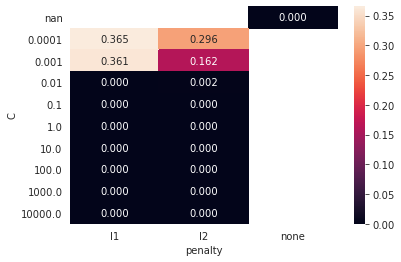

In [17]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

## Chess Dataset

https://archive.ics.uci.edu/ml/machine-learning-databases/chess/king-rook-vs-king/

In [67]:
chess = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/chess/king-rook-vs-king/krkopt.data')

# One hot encoding categorical features
encoder = OneHotEncoder().fit(chess[['draw']])
encoder.categories_

transformed = encoder.transform(chess[['draw']] ).toarray() 
transformed

for index, category in enumerate( np.concatenate(encoder.categories_) ):
    chess[category] = transformed[:,index]

# Drops strings and NaN so works in Grid Search
chess = chess.drop(columns = ['a', 'b', 'c'])
chess

,1,3,2,draw,eight,eleven,fifteen,five,four,fourteen,...,one,seven,six,sixteen,ten,thirteen,three,twelve,two,zero
0,1,1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28050,1,7,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28051,1,7,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28052,1,7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28053,1,7,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Stores all columns except draw in X and draw in Y
X_c = chess.drop(['draw'], axis=1)
Y_c = chess['draw']

In [20]:
# Gets 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, train_size = 5000, random_state = 1)

In [21]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [22]:
best_model.cv_results_

{'mean_fit_time': array([4.30783272e-02, 5.13204098e-01, 5.66349840e-01, 9.56201077e-02,
        1.02936792e+00, 2.61469984e-01, 5.32197552e+00, 3.12132397e+00,
        1.92838960e+01, 5.23759432e+00, 3.82463245e+01, 1.74995532e+01,
        5.20610068e+01, 1.16100789e+01, 2.32483387e+00, 1.68704591e+00,
        3.94978600e+00, 1.86819730e+00, 4.23526974e+00, 6.07757001e+00,
        1.13179618e+01, 2.04779655e+01, 3.00786271e+01, 3.44175791e+01,
        3.64756916e+01, 3.84185766e+01, 3.95975865e+01, 1.42975267e+01,
        1.37881291e+01]),
 'std_fit_time': array([ 0.04625285,  0.7939397 ,  1.01603564,  0.03342901,  1.20272228,
         0.26744238,  1.44389764,  2.50018192,  3.16311127,  1.30389968,
         4.25169442,  2.59544034,  3.55106053, 12.46458347,  0.09178186,
         0.03543865,  3.30050505,  0.11790524,  0.52442104,  2.17668542,
         1.40974349,  4.36966305,  4.5377706 ,  3.74443855,  5.8566035 ,
         5.11337329,  5.56397755,  3.12567891,  3.06645363]),
 'mean_sco

In [23]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19, 17, 15,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19, 15,  1,  1,  1,  1,  1,  1], dtype=int32)

In [24]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [25]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l2',
 'classifier__solver': 'saga'}

In [26]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [27]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

In [28]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=10.0, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0984
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0984
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0984
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0984
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0984
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0984
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0180
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0958
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0006
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0004


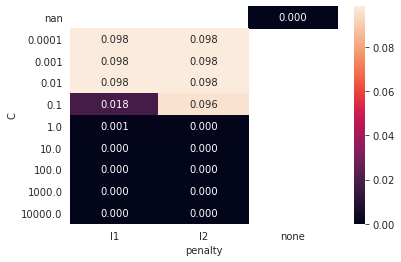

In [29]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [30]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, train_size = 5000, random_state = 2)

In [31]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [32]:
best_model.cv_results_

{'mean_fit_time': array([ 0.80042415,  0.11212091,  0.04531898,  0.10198822,  0.07958603,
         0.13964453,  2.02637191,  0.17073874,  4.49351277,  1.74289808,
        12.26901627,  3.47521749, 16.70730047,  7.7133009 , 15.20556655,
         8.99008555, 13.48700066,  3.59776387,  3.6565412 ,  4.85322309,
         9.27632165, 17.21895804, 29.1579525 , 30.27811656, 36.03672252,
        40.84031682, 41.06009965, 14.49555106, 15.14666839]),
 'std_fit_time': array([0.89965565, 0.00637474, 0.04631426, 0.06542048, 0.03957204,
        0.03843156, 3.49083324, 0.03835293, 2.97056018, 2.67762896,
        3.28205855, 3.26370133, 1.92498217, 0.88344179, 4.66852341,
        2.66028035, 3.58414568, 3.62398664, 0.3061207 , 0.61324729,
        1.02907263, 2.99570785, 3.72638739, 3.2100791 , 6.00892527,
        4.77024277, 5.66208239, 3.09355568, 5.19754021]),
 'mean_score_time': array([1.28021722, 0.5067255 , 0.51384678, 0.59939389, 0.62180862,
        0.4998167 , 0.47230239, 0.5496253 , 0.52621741,

In [33]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [34]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [35]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [36]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [37]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [38]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0888
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0888
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0888
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0888
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0888
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0888
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0220
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0882
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


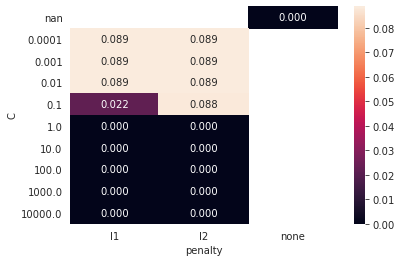

In [39]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [40]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, train_size = 5000, random_state = 3)

In [41]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)
                
best_model = clf.fit(X_train, Y_train)

In [44]:
best_model.cv_results_

{'mean_fit_time': array([2.64175892e-02, 1.36323738e-01, 1.01972532e-01, 1.21361780e-01,
        1.07807827e-01, 1.38226938e-01, 1.28756328e+00, 9.61018467e-01,
        4.10175061e+00, 1.72039118e+00, 1.04832869e+01, 3.18701367e+00,
        1.40050549e+01, 8.16633511e+00, 1.32994553e+01, 1.16142991e+01,
        7.14657483e+00, 1.77673092e+00, 3.57774687e+00, 4.31523819e+00,
        1.48781845e+01, 2.99594692e+01, 4.60183530e+01, 4.30373270e+01,
        4.45988726e+01, 5.54757504e+01, 4.74802027e+01, 2.09975017e+01,
        4.91698267e+01]),
 'std_fit_time': array([3.55075734e-02, 3.84208525e-02, 4.15863885e-03, 5.56173060e-02,
        2.23549981e-03, 3.18602675e-02, 2.03629081e+00, 1.57016971e+00,
        2.97226528e+00, 2.71709672e+00, 4.67939133e+00, 2.98427748e+00,
        2.98728934e+00, 3.22873968e+00, 3.79358681e+00, 6.11507461e+00,
        6.03762570e+00, 5.07860135e-02, 4.71142062e-01, 3.48332277e-01,
        3.26131990e+00, 5.11950637e+00, 3.24710462e+00, 2.44917840e+00,
     

In [45]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1,  1,  1], dtype=int32)

In [46]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [47]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [48]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [49]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [50]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0960
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0960
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0960
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0960
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0960
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0960
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0142
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0950
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


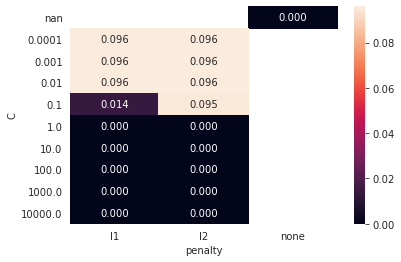

In [51]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [69]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, train_size = 5000, random_state = 4)

In [70]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [71]:
best_model = clf.fit(X_train, Y_train)

In [72]:
best_model.cv_results_

{'mean_fit_time': array([2.98724079e-01, 1.17199612e-01, 2.59222507e-02, 1.04938793e-01,
        7.15816498e-02, 1.22502232e-01, 4.38808641e+00, 1.81634521e-01,
        2.83593240e+00, 3.72183180e-01, 1.84304080e+00, 6.95680618e-01,
        2.07776217e+00, 1.39328465e+00, 2.24462891e+00, 2.53270350e+00,
        9.39907298e+00, 1.43103057e+01, 4.85460725e+00, 4.41808095e+00,
        9.25717044e+00, 1.95153400e+01, 2.79591665e+01, 2.77384836e+01,
        3.19960293e+01, 3.42925065e+01, 3.26389670e+01, 1.19768934e+01,
        1.84302649e+00]),
 'std_fit_time': array([3.55015844e-01, 7.24629179e-03, 3.54761151e-02, 3.77887244e-02,
        4.42922862e-02, 6.98501545e-03, 8.23860806e+00, 4.24177706e-02,
        2.48036018e+00, 4.50620388e-02, 8.98087418e-02, 6.52144949e-02,
        9.07458140e-02, 3.38998223e-02, 2.21953687e-01, 1.38740129e+00,
        6.98898503e+00, 6.30227010e+00, 2.00440395e+00, 3.64057244e-01,
        1.41570691e+00, 1.32076164e+00, 4.92173318e+00, 4.13085136e+00,
     

In [73]:
best_model.cv_results_['rank_test_accuracy']

array([21, 21, 21, 21, 21, 21, 18, 19,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 21, 21, 21, 19,  1,  1,  1,  1,  1, 17,  1], dtype=int32)

In [74]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [75]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [76]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [77]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

In [78]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0958
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0958
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0958
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0958
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0958
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0958
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0198
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0942
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0000
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0000


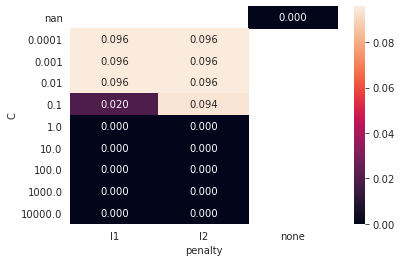

In [79]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results

In [80]:
# Gets another 5000 random samples
X_train, X_test, Y_train, Y_test = train_test_split(X_c, Y_c, train_size = 5000, random_state = 5)

In [81]:
# Grid Search
pipe = Pipeline([('classifier', LogisticRegression())])

search_space = [{'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['saga'],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs'],
                 'classifier__penalty': ['l2'],
                 'classifier__C': np.logspace(-4, 4, 9)},
                {'classifier': [LogisticRegression(max_iter=5000)],
                 'classifier__solver': ['lbfgs','saga'],
                 'classifier__penalty': ['none']}]
                
clf = GridSearchCV(pipe, search_space, cv=StratifiedKFold(n_splits=5), 
                   scoring=['accuracy', 'roc_auc_ovr', 'f1_micro'], refit=False,
                   verbose=0)

In [82]:
best_model = clf.fit(X_train, Y_train)

In [83]:
best_model.cv_results_

{'mean_fit_time': array([ 0.06358843,  0.13208117,  0.0469718 ,  0.11630583,  0.10741534,
         0.13033977,  0.3198153 ,  0.23095579,  1.21135917,  0.37684665,
         2.35480804,  1.04758859,  2.60616703,  1.46021519,  2.18445492,
         1.73411989,  2.21238532,  1.76545348,  3.99604645,  4.59531302,
         9.31666317, 16.85812306, 30.25956426, 25.65653133, 29.1978878 ,
        36.81690893, 37.81651921, 13.43811092,  1.90062747]),
 'std_fit_time': array([0.04417081, 0.03242355, 0.04477615, 0.07548336, 0.00677959,
        0.01866057, 0.03539519, 0.0127245 , 0.14381522, 0.04190533,
        0.06836611, 0.10082914, 0.47430039, 0.03905466, 0.09385948,
        0.06907562, 0.05415656, 0.01149096, 0.37611377, 0.37033755,
        0.82575733, 2.47446024, 2.02578991, 2.51151975, 3.10566311,
        2.43073175, 2.99948932, 1.13850093, 0.11168148]),
 'mean_score_time': array([0.7314774 , 0.74708323, 0.67386236, 0.66311398, 0.71254234,
        0.63048906, 0.70108018, 0.58786654, 0.68670287,

In [84]:
best_model.cv_results_['rank_test_accuracy']

array([19, 19, 19, 19, 19, 19, 18, 19, 15, 15,  1,  1,  1,  1,  1,  1,  1,
        1, 19, 19, 19, 19,  1,  1,  1,  1,  1, 15,  1], dtype=int32)

In [85]:
# finds best model for accuracy
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_accuracy'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [86]:
# finds best model for roc auc
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_roc_auc_ovr'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 1.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [87]:
# finds best model for f1
best_model.cv_results_['params'][ np.argmin(best_model.cv_results_['rank_test_f1_micro'])]

{'classifier': LogisticRegression(max_iter=5000),
 'classifier__C': 10.0,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [88]:
# best accuracy model
acc_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

# best roc auc model
roc_model = LogisticRegression(penalty = 'l1', C = 1.0, solver = 'saga', max_iter = 5000)

# best f1 model
f1_model = LogisticRegression(penalty = 'l1', C = 10.0, solver = 'saga', max_iter = 5000)

In [89]:
# models the data
acc_model.fit(X_train, Y_train)
roc_model.fit(X_train, Y_train)
f1_model.fit(X_train, Y_train)

LogisticRegression(C=10.0, max_iter=5000, penalty='l1', solver='saga')

,classifier,C,penalty,solver,score_acc
0,LogisticRegression(max_iter=5000),0.0001,l1,saga,0.0982
1,LogisticRegression(max_iter=5000),0.0001,l2,saga,0.0982
2,LogisticRegression(max_iter=5000),0.0010,l1,saga,0.0982
3,LogisticRegression(max_iter=5000),0.0010,l2,saga,0.0982
4,LogisticRegression(max_iter=5000),0.0100,l1,saga,0.0982
5,LogisticRegression(max_iter=5000),0.0100,l2,saga,0.0982
6,LogisticRegression(max_iter=5000),0.1000,l1,saga,0.0140
7,LogisticRegression(max_iter=5000),0.1000,l2,saga,0.0982
8,LogisticRegression(max_iter=5000),1.0000,l1,saga,0.0002
9,LogisticRegression(max_iter=5000),1.0000,l2,saga,0.0002


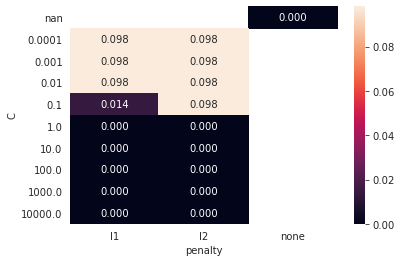

In [90]:
results = pd.DataFrame( best_model.cv_results_['params'] )

results['score_acc'] = 1 - best_model.cv_results_['mean_test_accuracy']

cols = results.columns.to_series().str.split('__').apply(lambda x: x[-1])
results.columns = cols

# Heat map
sns.heatmap( results.query('solver=="saga"').pivot('C','penalty','score_acc'),
             annot=True, fmt='.3f')

results